In [1]:
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import import_ipynb
from model import NeuralNet
from spacy_utils import load_glove_embeddings, sentence_embedding, tokenize_and_normalize

### Load Glove

In [2]:
glove_path = "glove.6B.300d.txt"
emb_dim = 300
word2vec = load_glove_embeddings(glove_path, emb_dim=emb_dim)

import pickle
# Save GloVe dictionary to a .pkl file for use during inference
with open("glove_embeddings.pkl", "wb") as f:
    pickle.dump(word2vec, f)
print("✅ Saved glove_embeddings.pkl")

✅ Saved glove_embeddings.pkl


### Load Training Dataset

In [3]:
with open("trainingDataset.json", "r") as f:
    data_json = json.load(f)
intents = data_json["intents"]

tags = []
xy = []
for intent in intents:
    tag = intent["tag"]
    if tag not in tags:
        tags.append(tag)
    for pattern in intent["patterns"]:
        tokens = tokenize_and_normalize(pattern)
        emb_vec = sentence_embedding(tokens, word2vec, emb_dim)
        xy.append((emb_vec, tag))

In [4]:
tags = sorted(tags)

In [5]:
print("All tags:", tags)

All tags: ['alias_command', 'bootloader_info', 'change_directory', 'change_hostname', 'check_cpu_usage', 'check_disk_health', 'check_memory_usage', 'check_open_ports', 'check_uptime', 'compress_files', 'copy_files', 'create_symlink', 'create_user', 'cron_advanced', 'cron_jobs', 'current_directory', 'delete_files', 'delete_user', 'disk_partition', 'disk_usage', 'docker_commands', 'edit_file', 'extract_files', 'file_permissions', 'file_permissions_check', 'firewall_configuration', 'git_commands', 'goodbye', 'greeting', 'help', 'inspect_package', 'install_software', 'kill_process', 'ldap_authentication', 'list_files', 'lvm_management', 'make_directory', 'mount_drive', 'move_files', 'network_info', 'nginx_setup', 'processes', 'python_env_setup', 'reboot_system', 'remove_directory', 'search_files', 'search_text', 'service_management', 'set_environment_variable', 'shutdown_system', 'ssh_connection', 'system_info', 'update_permissions_recursive', 'update_system', 'view_logs', 'virtualization'

In [6]:
print("Number of training samples:", len(xy))

Number of training samples: 1608


### Prepare xy arrays

In [7]:
xTrain = []
yTrain = []
for (vec, tag) in xy:
    xTrain.append(vec)
    yTrain.append(tags.index(tag))

xTrain = np.array(xTrain, dtype=np.float32)
yTrain = np.array(yTrain)

# Split into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)

### Dataset and DataLoader

In [8]:
class ChatDataset(Dataset):
    def __init__(self, X, Y):
        self.xData = torch.from_numpy(X).float()
        self.yData = torch.tensor(Y, dtype=torch.long)
        self.nSamples = len(X)

    def __getitem__(self, idx):
        return self.xData[idx], self.yData[idx]

    def __len__(self):
        return self.nSamples

trainDataset = ChatDataset(x_train, y_train)
valDataset = ChatDataset(x_val, y_val)
trainLoader = DataLoader(dataset=trainDataset, batch_size=8, shuffle=True)
valLoader = DataLoader(dataset=valDataset, batch_size=8, shuffle=False)

### Hyperparameters

In [9]:
# Model parameters
embSize = emb_dim
hiddenSize = 64
numClasses = len(tags)

### Initializing Network

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet(embSize, hiddenSize, numClasses).to(device)

### Training Preparation

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Training loop with early stopping
numEpochs = 200
train_losses, val_losses = [], []
best_val_loss = float('inf')

patience, patience_counter = 10, 0
# Initialize lists to store metrics
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1_scores, val_f1_scores = [], []

### Training Loop

In [12]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

for epoch in range(numEpochs): #will work for 200 epochs
    model.train() #sets the NeuralNet instance into training mode which specifies that we are now going to train our chatbot using this instance of NN
    running_loss = 0.0 #calculates the cumulative loss for a particular epoch
    all_train_labels, all_train_preds = [], [] #stores the actual label and the predicted label

    for words, labels in trainLoader: #trainloader loads randomly any 8 datapoints i.e. their sentence embeddings in words tenson and their actual or true labels in labels tensor
        words, labels = words.to(device), labels.to(device) #Here we are moving our tensors words and labels into the specified device for processing be it GPU or CPU

        # Forward pass
        outputs = model(words) #words is basically our input to the Neural Network which will compute the logits tensor for each sentence embedding and create a tensor of tensors and return it to us.
        loss = criterion(outputs, labels) #average loss of all the sentence embeddings in the batch

        # Backward pass and optimization
        optimizer.zero_grad() #Clears the grad of all the weights and biases eg. w1.grad, w2.grad, w3.grad...
        loss.backward() #It will plot the 
        optimizer.step()

        running_loss += loss.item() #loss was a tensor with one value. It's scalar value is added into the running_loss
        _, predicted = torch.max(outputs, 1) #torch.max takes the outputs tensor containing the logits list for each of the 8 data points. It returns two lists one containing the maximum logits of each of the 8 data points and another list containing the index of the tag to which it belongs. _ is used to ignore the maximum logits and predicted is used to store the indices of the maximum logits for each of the 8 data points.
        all_train_labels.extend(labels.cpu().numpy()) #current batch ke true labels ko hamne all_train_labels naam ke list me add kardiya hai. We have done .cpu().numpy() to specify ki hamara jo tensor hai wo numpy convert hogaya hai and since numpy requires cpu for easy execution we have specified .cpu() for execution
        all_train_preds.extend(predicted.cpu().numpy()) #The indexes of the predicted tags are stored in predicted. We are adding the predicted tags of the current batch into all_train_preds. We are first moving the tensor into the CPU if it is on GPU and then converting it to NUMPY for execution

    # Calculate training metrics
    train_loss = running_loss / len(trainLoader) #dividing the running loss by total number of batches. len(trainLoader) = total number of training instances / batch size
    train_losses.append(train_loss) #loss after each epoch is stored here

    train_acc = accuracy_score(all_train_labels, all_train_preds) #Finds the training accuracy for the current epoch by dividing total number of correct predictions with total number of predictions
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
    all_train_labels, all_train_preds, average="weighted", zero_division=0
    ) #Each meteric is calculated for each class and then all the meterics are averaged if division by zero occurs then error is not raised simply zero is returned

    train_accuracies.append(train_acc)
    train_precisions.append(train_prec)
    train_recalls.append(train_rec)
    train_f1_scores.append(train_f1)

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_val_labels, all_val_preds = [], []
    
    with torch.no_grad():
        for words, labels in valLoader:
            words, labels = words.to(device), labels.to(device)

            outputs = model(words)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    # Calculate validation metrics
    val_loss /= len(valLoader) 
    val_losses.append(val_loss)

    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        all_val_labels, all_val_preds, average="weighted", zero_division=0
    )

    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_f1_scores.append(val_f1)

    # Early stopping logic (same as before)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{numEpochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Prec: {train_prec:.4f}, "
          f"Train Rec: {train_rec:.4f}, Train F1: {train_f1:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Prec: {val_prec:.4f}, "
          f"Val Rec: {val_rec:.4f}, Val F1: {val_f1:.4f}")


Epoch [1/200], Train Loss: 3.9564, Train Acc: 0.0614, Train Prec: 0.0757, Train Rec: 0.0614, Train F1: 0.0429, Val Loss: 3.6144, Val Acc: 0.1801, Val Prec: 0.1837, Val Rec: 0.1801, Val F1: 0.1141
Epoch [2/200], Train Loss: 3.1268, Train Acc: 0.2247, Train Prec: 0.2154, Train Rec: 0.2247, Train F1: 0.1870, Val Loss: 2.5204, Val Acc: 0.4876, Val Prec: 0.5493, Val Rec: 0.4876, Val F1: 0.4515
Epoch [3/200], Train Loss: 2.2487, Train Acc: 0.4145, Train Prec: 0.4320, Train Rec: 0.4145, Train F1: 0.3966, Val Loss: 1.7375, Val Acc: 0.6615, Val Prec: 0.6826, Val Rec: 0.6615, Val F1: 0.6370
Epoch [4/200], Train Loss: 1.6980, Train Acc: 0.5420, Train Prec: 0.5264, Train Rec: 0.5420, Train F1: 0.5249, Val Loss: 1.3497, Val Acc: 0.7050, Val Prec: 0.6974, Val Rec: 0.7050, Val F1: 0.6754
Epoch [5/200], Train Loss: 1.3620, Train Acc: 0.6376, Train Prec: 0.6291, Train Rec: 0.6376, Train F1: 0.6231, Val Loss: 1.1325, Val Acc: 0.7422, Val Prec: 0.7676, Val Rec: 0.7422, Val F1: 0.7288
Epoch [6/200], Train

### Plot Loss and Accuracy

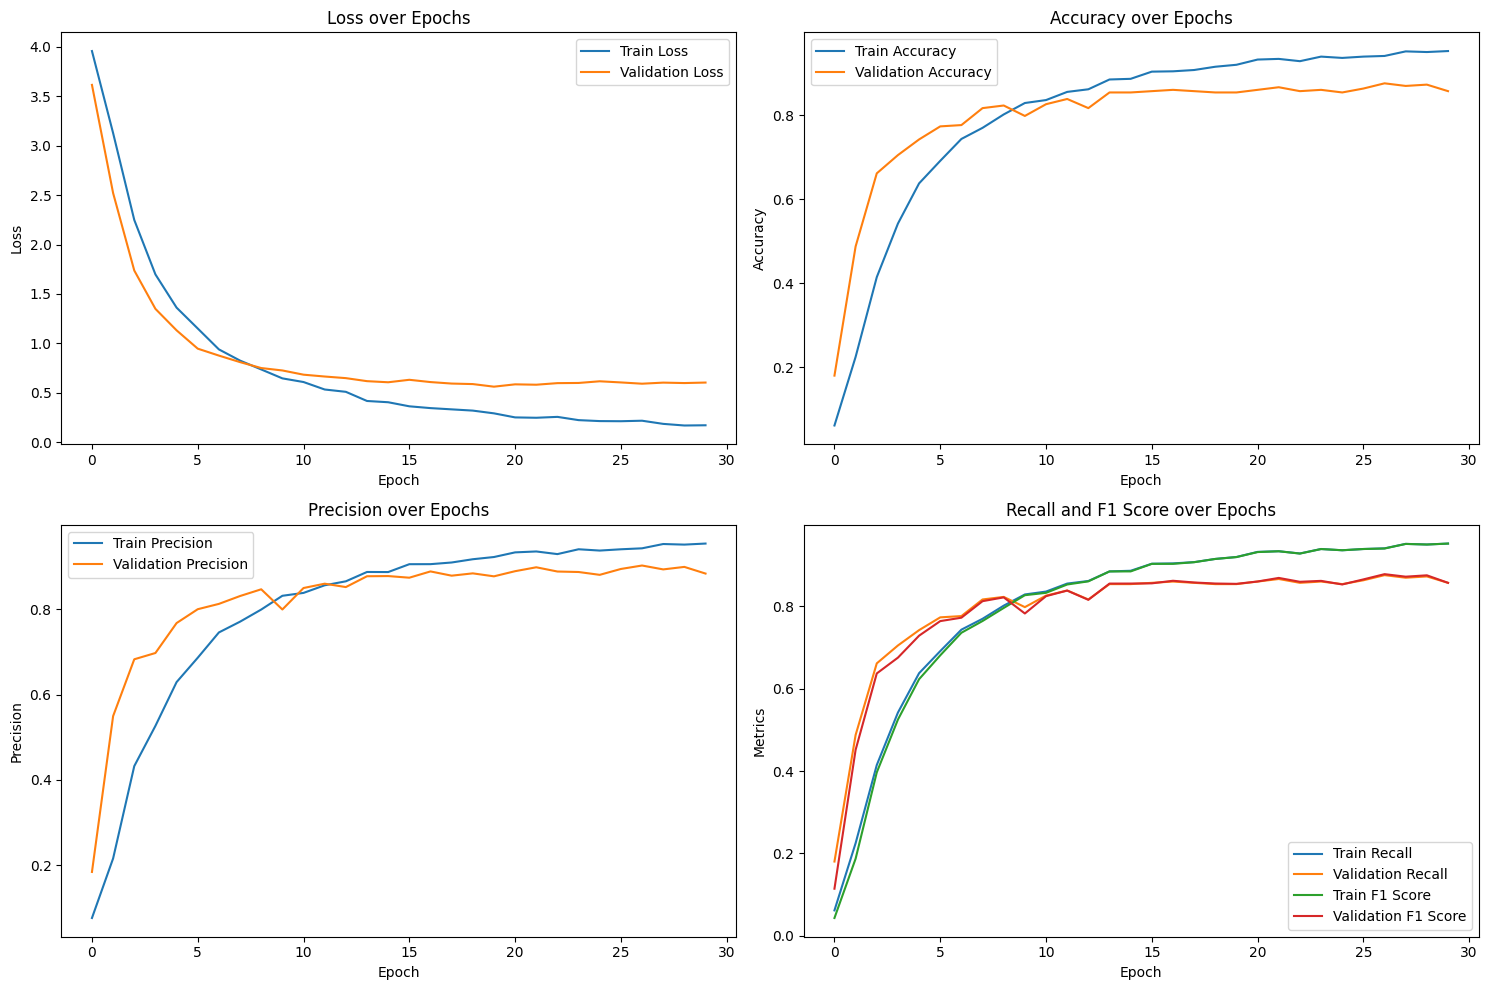

In [13]:
 # Plot training and validation metrics
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, label="Train Accuracy")
plt.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(range(len(train_precisions)), train_precisions, label="Train Precision")
plt.plot(range(len(val_precisions)), val_precisions, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision over Epochs")
plt.legend()

# Recall and F1 Score
plt.subplot(2, 2, 4)
plt.plot(range(len(train_recalls)), train_recalls, label="Train Recall")
plt.plot(range(len(val_recalls)), val_recalls, label="Validation Recall")
plt.plot(range(len(train_f1_scores)), train_f1_scores, label="Train F1 Score")
plt.plot(range(len(val_f1_scores)), val_f1_scores, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.title("Recall and F1 Score over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### Saving Model

In [14]:
data = {
    "model_state": model.state_dict(),  # Model's weights
    "optimizer_state": optimizer.state_dict(),  # Optimizer's state
    "emb_size": embSize,  # Embedding size (input size)
    "hidden_size": hiddenSize,  # Hidden layer size
    "num_classes": numClasses,  # Number of output classes
    "tags": tags,  # List of class labels (intents)
    "train_losses": train_losses,  # Training loss per epoch
    "val_losses": val_losses,  # Validation loss per epoch
    "train_accuracies": train_accuracies,  # Training accuracy per epoch
    "val_accuracies": val_accuracies,  # Validation accuracy per epoch
    "train_precisions": train_precisions,  # Training precision per epoch
    "val_precisions": val_precisions,  # Validation precision per epoch
    "train_recalls": train_recalls,  # Training recall per epoch
    "val_recalls": val_recalls,  # Validation recall per epoch
    "train_f1_scores": train_f1_scores,  # Training F1 score per epoch
    "val_f1_scores": val_f1_scores,  # Validation F1 score per epoch
}
FILE = "model_and_metadata.pth"
torch.save(data, FILE)
print(f"Model and metadata saved to {FILE}")

Model and metadata saved to model_and_metadata.pth
